# Import Libraries

In [1]:
import openmeteo_requests

from datetime import datetime,date,timedelta
import requests_cache
import pandas as pd
import numpy as np
from retry_requests import retry

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import warnings
warnings.filterwarnings('ignore')

https://open-meteo.com/en/docs/historical-weather-api?

## Define Functions

In [2]:
def get_7_days_weeks(df, num_past_weeks=4, num_future_weeks=4):
    
    """
    Assigns week labels based on past and future 7-day periods.

    Parameters:
    df (pd.DataFrame): DataFrame containing a 'date' column (datetime format).
    num_past_weeks (int): Number of past weeks to include.
    num_future_weeks (int): Number of future weeks to include.

    This function can only go back to the beginning of the year for the maximum value in df['date'].
    asdasd
    Returns:
    np.array: Array of calculated week start dates. (The assigned year will be year for the maximum value in df['date'])
    """

    years=df['date'].dt.year.unique()

    choices=[]
    conditions=[]
    max_date = df['date'].max()
    # print(max_date)
    for week in list(range(-num_past_weeks, num_future_weeks)):
        x=(max_date + timedelta(days=(7 * week)+1))
        if x.year == max_date.year:
            week_start_month_day=x.strftime('%m-%d')
            for year in years:        
                week_start = pd.to_datetime(f"{year}-{week_start_month_day}",format='%Y-%m-%d')
                week_end = week_start + timedelta(days=6)
                
                conditions.append((week_start <= df['date']) & (df['date'] <= week_end))
                choices.append(f"{max_date.year}-{week_start_month_day}")
                
                #print(f"max_date:{max_date}, {week}:,{week_start_month_day}, {max_date.year}-{week_start_month_day}, {year}, {week_start} - {week_end} ")
    
    return np.select(conditions, choices, default=None)

In [3]:
locations = {
    # Countries
    "Netherlands": {"latitude": 52.1326, "longitude": 5.2913},
    "Turkey": {"latitude": 38.9637, "longitude": 35.2433},

    # Netherlands Cities
    "Amsterdam": {"latitude": 52.3676, "longitude": 4.9041},
    "Rotterdam": {"latitude": 51.9244, "longitude": 4.4777},
    "The Hague": {"latitude": 52.0705, "longitude": 4.3007},
    "Utrecht": {"latitude": 52.0907, "longitude": 5.1214},
    "Eindhoven": {"latitude": 51.4416, "longitude": 5.4697},
    "Groningen": {"latitude": 53.2194, "longitude": 6.5665},
    "Maastricht": {"latitude": 50.8514, "longitude": 5.6900},
    "Tilburg": {"latitude": 51.5555, "longitude": 5.0913},
    "Breda": {"latitude": 51.5719, "longitude": 4.7683},
    "Nijmegen": {"latitude": 51.8126, "longitude": 5.8372},
    "Haarlem": {"latitude": 52.3874, "longitude": 4.6462},
    "Leeuwarden": {"latitude": 53.2012, "longitude": 5.7999},
    
    # Turkey Cities
    "Istanbul": {"latitude": 41.0082, "longitude": 28.9784},
    "Izmir": {"latitude": 38.4192, "longitude": 27.1287},
    "Ankara": {"latitude": 39.9334, "longitude": 32.8597},
}

In [4]:
%%time 

from_date="2022-01-01"
location_name= 'Netherlands'
## ['Netherlands', 'Italy', 'Turkey', 'Spain', 'Amsterdam', 'Rotterdam', 'The Hague', 'Utrecht', 'Eindhoven', 'Groningen', 'Maastricht', 'Tilburg', 'Breda', 'Nijmegen', 'Haarlem', 'Leeuwarden', 
## 'Pisa', 'Rome', 'Milan', 'Naples', 'Istanbul', 'Izmir', 'Ankara', 'Sevilla', 'Granada', 'Cordoba']

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": locations[location_name]['latitude'],
	"longitude": locations[location_name]['longitude'],
	"start_date": from_date,
	"end_date": date.today().strftime("%Y-%m-%d"),
	"daily": ["temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "sunrise", "sunset", "daylight_duration", "sunshine_duration", "precipitation_sum", "precipitation_hours"],
	#"timezone": "Europe/Berlin"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"{location_name} : Coordinates {response.Latitude()}°N {response.Longitude()}°E ")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(2).ValuesAsNumpy()
daily_sunrise = daily.Variables(3).ValuesAsNumpy()
daily_sunset = daily.Variables(4).ValuesAsNumpy()
daily_daylight_duration = daily.Variables(5).ValuesAsNumpy()
daily_sunshine_duration = daily.Variables(6).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(7).ValuesAsNumpy()
daily_precipitation_hours = daily.Variables(8).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["temperature_2m_max"] = daily_temperature_2m_max # max temperature measured at a height of 2 meters
daily_data["temperature_2m_min"] = daily_temperature_2m_min # min temperature measured at a height of 2 meters
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean # average temperature measured at a height of 2 meters
daily_data["sunrise"] = daily_sunrise
daily_data["sunset"] = daily_sunset
daily_data["daylight_duration"] = daily_daylight_duration # (seconds) Number of seconds of daylight per day
daily_data["sunshine_duration"] = daily_sunshine_duration # (seconds) The number of seconds of sunshine per day is determined by calculating direct normalized irradiance exceeding 120 W/m², following the WMO definition.
daily_data["precipitation_sum"] = daily_precipitation_sum # (mm) Sum of daily precipitation (including rain, showers and snowfall)
daily_data["precipitation_hours"] = daily_precipitation_hours



daily_dataframe = pd.DataFrame(data = daily_data).dropna()
daily_dataframe['date'] = daily_dataframe['date'].dt.tz_localize(None)
daily_dataframe = daily_dataframe.astype({'date': 'datetime64[ns]'})

daily_dataframe["location_name"] = location_name
daily_dataframe['week_start'] = get_7_days_weeks(
    daily_dataframe, 
    num_past_weeks=13, 
    num_future_weeks=20
)

daily_dataframe

Netherlands : Coordinates 52.12653732299805°N 5.303867340087891°E 
Elevation 44.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
Wall time: 174 ms


,date,temperature_2m_max,temperature_2m_min,temperature_2m_mean,sunrise,sunset,daylight_duration,sunshine_duration,precipitation_sum,precipitation_hours,location_name,week_start
0,2022-01-01,12.879001,9.979000,11.474833,0,0,28180.414062,9675.756836,0.600000,1.0,Netherlands,None
1,2022-01-02,12.779000,9.129001,11.033168,0,0,28252.519531,14325.765625,9.200001,12.0,Netherlands,None
2,2022-01-03,9.929000,7.329000,8.354001,0,0,28330.759766,22669.630859,1.000000,3.0,Netherlands,None
3,2022-01-04,7.879000,2.429000,5.993583,0,0,28415.986328,1638.136108,2.700000,12.0,Netherlands,2025-01-04
4,2022-01-05,6.479000,2.229000,4.051917,0,0,28508.115234,7441.703125,6.700000,12.0,Netherlands,2025-01-04
...,...,...,...,...,...,...,...,...,...,...,...,...
1185,2025-03-31,11.129001,3.979000,7.729001,0,0,46550.148438,41910.402344,0.000000,0.0,Netherlands,2025-03-29
1186,2025-04-01,13.479000,1.779000,7.733168,0,0,46791.851562,42128.062500,0.000000,0.0,Netherlands,2025-03-29
1187,2025-04-02,16.229000,4.929000,10.441501,0,0,47033.921875,42400.644531,0.000000,0.0,Netherlands,2025-03-29
1188,2025-04-03,18.979000,8.179000,13.049834,0,0,47276.210938,42704.894531,0.000000,0.0,Netherlands,2025-03-29


## Plot Weekly data for metrics

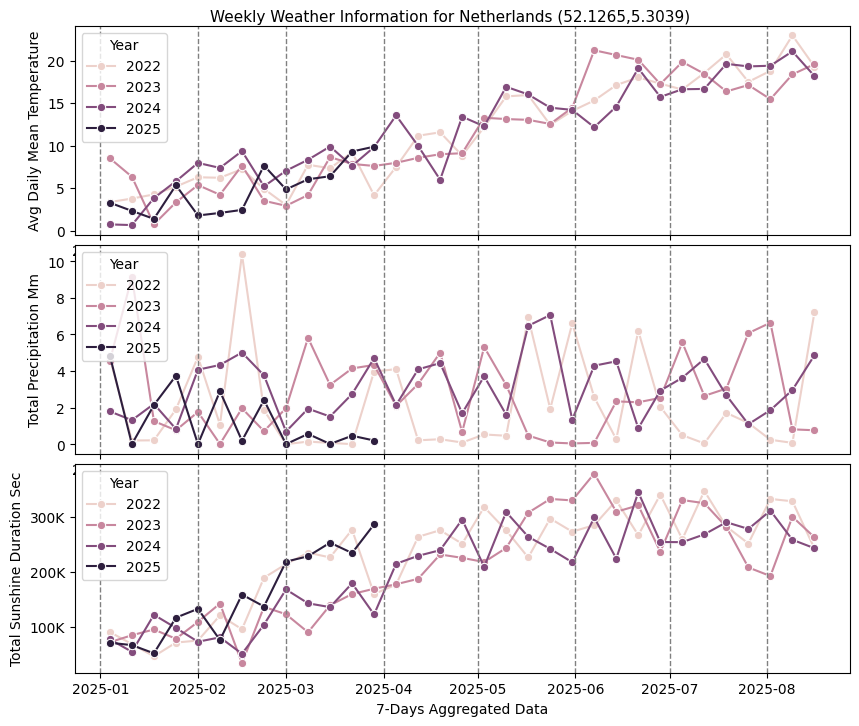

In [5]:
df_plot = (
    daily_dataframe
    .eval("Year=date.dt.year")
    .groupby(['week_start','Year'],as_index=False)
    .agg(
        min_date=("date","min"),
        max_date=("date","max"),
        n_days=("date","nunique"),
        avg_daily_mean_temperature=("temperature_2m_mean","mean"),
        total_precipitation_mm=("precipitation_sum","mean"),
        total_sunshine_duration_sec=("sunshine_duration","sum"),
    )
    .astype({'week_start': 'datetime64[ns]'})
    .round(2)
)

# List of metrics
metrics = ['avg_daily_mean_temperature','total_precipitation_mm','total_sunshine_duration_sec']

# Create the subplots
fig, axes = plt.subplots(
    nrows=len(metrics), 
    figsize=(10, len(metrics)*2.80), 
    gridspec_kw={"hspace": 0.05},
    constrained_layout=True,
    #figsize=(10 * ncols, 4 * nrows),
    sharex=False
)

#sns.plotting_context("whitegrid")

# Loop through each metric and plot
for i, metric in enumerate(metrics):
    ax = axes[i]  # Select the corresponding subplot axis
    
    # Line plot
    sns.lineplot(
        data=df_plot, 
        x='week_start', 
        y=metric, 
        hue='Year', 
        marker='o', 
        dashes=False,  # Ensures all lines are solid
        #palette='rocket', 
        ax=ax
    )
    
    # Custom y-axis formatter
    def custom_formatter(x, _):
        if x >= 1e6:
            return f'{x/1e6:.1f}M'
        elif x >= 1e3:
            return f'{x/1e3:.0f}K'
        else:
            return f'{x:.0f}'
    ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))

    # Add gray dashed vertical lines at the start of each month
    for month_start in df_plot['week_start'].dt.to_period('M').dt.start_time.unique():
        ax.axvline(x=month_start, color='gray', linestyle='--', linewidth=1)
    # Rotate the x-axis tick labels
    ax.tick_params(axis='x', rotation=0)

    # Add labels and title
    ax.set_xlabel('7-Days Aggregated Data')
    ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=10)
    ax.legend(title='Year', loc='upper left')

# Adjust layout to prevent overlap

fig.suptitle(f"Weekly Weather Information for {location_name} ({round(response.Latitude(),4)},{round(response.Longitude(),4)})", fontsize=11, y=0.90)
plt.tight_layout()
plt.show()